In [1]:
import sys
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import math
import time
from sklearn.model_selection import train_test_split

(100, 50)


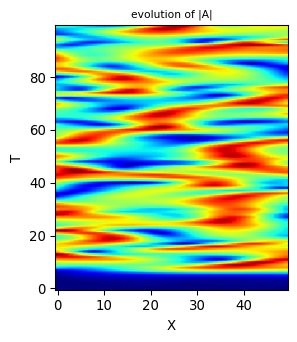

(9440, 64)


'\n#Armo un par (x,t)\nfor i in range(len(X)):\n    for j in range(len(Tdata)):\n        data.append(y_[j][i])\n        \n        if maxY < abs(y_[j][i]):\n          maxY = abs(y_[j][i])\n          \n\n            \n\nX_ = data[:-1]\nY = data[1:]\n\n\n# En caso de tener mas de una variable dependiente con diferente escala\nmu1, sigma1 = np.mean( X_ ), np.std( X_ )\nmu2, sigma2 = np.mean( y_ ), np.std( y_ )\n\nX_ = (X_ - mu1) / sigma1\nY = (Y - mu2) / sigma2\n\nlenX = int(0.9*X_.shape[0])\nlenY = int(0.9*Y.shape[0])\n\n# Separacion de dataset en training y testing\nxTrain, xPredict = X_[:lenX], X_[lenX:]\nyTrain, yPredict = Y[:lenY], Y[lenX:]\n\n\n#Formo 16 cuadrados de 32*32 para tener mas datos para entrenar\n#xTrain = np.reshape( np.array( np.split( xTrain, 4, axis=1)), (-1, 8) )\n#yTrain = np.reshape( np.array( np.split( yTrain, 4, axis=1)), (-1, 8) )\n\nprint(X_.shape)\n\n'

In [2]:
import mat73

f = mat73.loadmat('Solucion.mat')
Y_Data = np.array(f['U']) # For converting to a NumPy array

for i in range(1,13):

  a = 'Solucion' + str(i)  + '.mat'

  f = mat73.loadmat(a)
  Y_Data1 = np.array(f['U']) # For converting to a NumPy array
  
  Y_Data = np.append(Y_Data,Y_Data1, axis=0)

y_graph = np.transpose(Y_Data[:100])
y_graph = np.transpose(y_graph[:50])
print(y_graph.shape)

y_ = Y_Data
#Cargo las series X
f = mat73.loadmat('3erCaso_Xserie.mat')
X = f['X']# For converting to a NumPy array

f = mat73.loadmat('3erCaso_Tserie.mat')
Tdata = f['Tdata'] # For converting to a NumPy array


plt.figure(figsize=(300/96,350/96), dpi=96)
plt.imshow(y_graph, aspect='auto', cmap='jet' , origin='lower')
plt.title('evolution of |A|', fontsize=8)
plt.xlabel('X')
plt.ylabel('T')
plt.savefig('puerba1')
plt.show()


X_ = y_[:-1,:]
Y = y_[1:,:]


# En caso de tener mas de una variable dependiente con diferente escala
mu1, sigma1 = np.mean( X_ ), np.std( X_ )
mu2, sigma2 = np.mean( y_ ), np.std( y_ )

X_ = (X_ - mu1) / sigma1
Y = (Y - mu2) / sigma2

lenX = int(0.9*X_.shape[0])
lenY = int(0.9*Y.shape[0])

# Separacion de dataset en training y testing
xTrain = X_[:lenX, :]
yTrain = Y[:lenY, :]


#Formo 16 cuadrados de 32*32 para tener mas datos para entrenar
xTrain = np.reshape( np.array( np.split( xTrain, 512/64, axis=1)), (-1, 64) )
yTrain = np.reshape( np.array( np.split( yTrain, 512/64, axis=1)), (-1, 64) )
print(xTrain.shape)

#------------------------------------------------------------------------
'''
#Armo un par (x,t)
for i in range(len(X)):
    for j in range(len(Tdata)):
        data.append(y_[j][i])
        
        if maxY < abs(y_[j][i]):
          maxY = abs(y_[j][i])
          

            

X_ = data[:-1]
Y = data[1:]


# En caso de tener mas de una variable dependiente con diferente escala
mu1, sigma1 = np.mean( X_ ), np.std( X_ )
mu2, sigma2 = np.mean( y_ ), np.std( y_ )

X_ = (X_ - mu1) / sigma1
Y = (Y - mu2) / sigma2

lenX = int(0.9*X_.shape[0])
lenY = int(0.9*Y.shape[0])

# Separacion de dataset en training y testing
xTrain, xPredict = X_[:lenX], X_[lenX:]
yTrain, yPredict = Y[:lenY], Y[lenX:]


#Formo 16 cuadrados de 32*32 para tener mas datos para entrenar
#xTrain = np.reshape( np.array( np.split( xTrain, 4, axis=1)), (-1, 8) )
#yTrain = np.reshape( np.array( np.split( yTrain, 4, axis=1)), (-1, 8) )

print(X_.shape)

'''

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD, Adagrad, Adadelta
from tensorflow.keras.callbacks import EarlyStopping

from numpy import genfromtxt
np.random.seed(42)

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)


data = y_

# global variables
shift_k = 0

res_params = {
             'train_length': xTrain.shape[0],
             'predict_length': data.shape[0]-xTrain.shape[0]
              }

train = xTrain
label = yTrain

print('np.shape(train)', np.shape(train))
print('np.shape(label)', np.shape(label))



y_train = label - train
x_train = train
print('np.shape(y_train)', np.shape(y_train))
print('np.shape(x_train)', np.shape(x_train))



model = Sequential()
model.add(Dense(64, input_dim=64, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(64, activation='tanh'))

model.compile(loss='mean_absolute_error', optimizer='SGD', metrics=['mae'])
print(model.summary())

es = EarlyStopping(monitor='loss',   #controlo el error
                       mode='min',            #si asciende corta
                       min_delta = 0.0001,
                       patience=300,           #paciencia para que siga si es q sube porque hay ruido
                       restore_best_weights=True,  #se queda con la mejor
                       verbose=True)

class Nprint(tf.keras.callbacks.Callback):
    def __init__(self):
        self.t0 = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
            keys = list(logs.keys())
            if epoch % 100 == 0:
                t1 = time.time()
                telap = round(t1 - self.t0,3)
                print("For epoch {:5d}, loss = {:7.4f}, val_loss = {:7.4f}, time elapsed {} seg".format(epoch, logs["loss"], logs["val_loss"], telap))
                self.t0=time.time()


Using TensorFlow backend.


np.shape(train) (9440, 64)
np.shape(label) (9440, 64)
np.shape(y_train) (9440, 64)
np.shape(x_train) (9440, 64)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6464      
Total pa

For epoch     0, loss =  0.5706, val_loss =  0.5664, time elapsed 1.101 seg
For epoch   100, loss =  0.4767, val_loss =  0.4826, time elapsed 14.128 seg
For epoch   200, loss =  0.4639, val_loss =  0.4695, time elapsed 14.076 seg
For epoch   300, loss =  0.4403, val_loss =  0.4458, time elapsed 14.065 seg
For epoch   400, loss =  0.4158, val_loss =  0.4212, time elapsed 14.483 seg
For epoch   500, loss =  0.4005, val_loss =  0.4147, time elapsed 16.419 seg
For epoch   600, loss =  0.3904, val_loss =  0.4020, time elapsed 18.689 seg
For epoch   700, loss =  0.3830, val_loss =  0.3942, time elapsed 18.662 seg
For epoch   800, loss =  0.3778, val_loss =  0.3914, time elapsed 18.641 seg
For epoch   900, loss =  0.3731, val_loss =  0.3856, time elapsed 18.491 seg


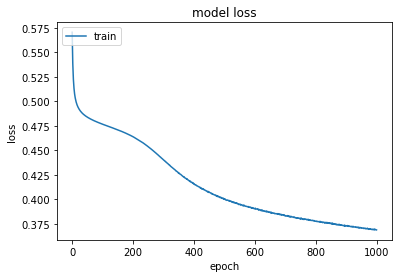

In [4]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_split=0.1, shuffle=True, verbose = 0, callbacks=[es,Nprint()])
model.save_weights("./weights_Shift"+str(shift_k)+"K")

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [113]:
print ('Read reference state')

f = mat73.loadmat('Solucion.mat')
data = np.array(f['U']) # For converting to a NumPy array


# Load the reference state
ref_state = np.atleast_2d(data[96,:])
totalData = data[:96,:]
print(totalData.shape)
print('np.shape(ref_state)',np.shape(ref_state))

train_y = data[96:,:]
print('np.shape(train_y)',np.shape(train_y))

n_dummy = np.shape(ref_state)
n_forecasts = 1
#n_steps =  n_dummy[1]
n_steps = 100-96

fore_state = np.zeros((n_forecasts*(n_steps+1),512))
print(fore_state.shape)
state = np.zeros((n_forecasts*(n_steps+1),512))
state_n = np.zeros((1,64))

out0 = np.zeros((64,1))
out1 = out0
out2 = out0
out3 = out0


mask = np.zeros( 512 )

# Get the last point from the training as the starting point of forcasting
state[:] = train_y[0,:]
fore_state[0,:] = state[0,:]
for j in range(n_steps):
    mask = np.zeros( 512 )
    for i in range(0,512-64+1,4):
    
        out3=out2
        out2=out1
        state_n[0,:] = state[j,i:i+64]
       
        out1 = model.predict(state_n,batch_size=1)
        
        if j==0:
            out0 = out1
        if j==1:
            out0 = 1.5*out1-0.5*out2
        if j>1:
            out0 = (23.0/12.0)*out1-(4.0/3.0)*out2+(5.0/12.0)*out3
       
        state[j+1,i:i+64] = state[j,i:i+64] + out0
        fore_state[1*(0)+j+1,i:i+64] = state[j+1,i:i+64]
    mask[i:i+64]+= 1
    fore_state[j] = np.divide( fore_state[j], mask )

totaData = np.append(totalData,fore_state,axis = 0)

print(fore_state.shape)
#np.savetxt('output_ANN'+ 'shift'+str(shift_k)+ 'trainN' + str(res_params['train_length'])+'.csv',fore_state,delimiter=',')
#np.savetxt('truth_ANN'+ 'shift'+str(shift_k)+ 'trainN' + str(res_params['train_length'])+'.csv',ref_state,delimiter=',')
print('done')

Read reference state
(50, 512)
np.shape(ref_state) (1, 512)
np.shape(train_y) (50, 512)
(51, 512)
(51, 512)
done


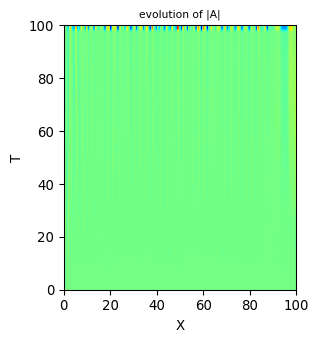

In [115]:
plt.figure(figsize=(300/96,350/96), dpi=96)
plt.imshow(fore_state, extent=[0, 100, 0, 100], aspect='auto', cmap='jet' , origin='lower')
plt.title('evolution of |A|', fontsize=8)
plt.xlabel('X')
plt.ylabel('T')
plt.savefig('puerba1')
plt.show()